In [2]:
#Importing Necessary Libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg19 import preprocess_input
from PIL import Image
from google.colab import files

In [3]:
#Installing the required library for image processing using TensorFlow
!pip install tensorflow matplotlib numpy Pillow


In [4]:
#Uploading Content & Style Image
print("Upload the Content Image:")
content_path = files.upload()
content_image_path = list(content_path.keys())[0]

print("Upload the Style Image:")
style_path = files.upload()
style_image_path = list(style_path.keys())[0]

Upload the Content Image:


Saving city.jpeg to city.jpeg
Upload the Style Image:


Saving Night.jpg to Night.jpg


In [5]:
#Function for load and process image
def load_and_process_image(image_path, target_size=(512, 512)):
    img = Image.open(image_path).convert("RGB")  #It Ensure 3-channel image
    img = img.resize(target_size)  #Resizing image to desired target size
    img = img_to_array(img)  #Converting image to numpy array
    img = np.expand_dims(img, axis=0)  #Adding batch dimension
    img = preprocess_input(img)  #Preprocessing image for VGG19 model
    return tf.convert_to_tensor(img, dtype=tf.float32)  #Converting for tensor

# Function for deprocess image
def deprocess_image(img_tensor):
    img = img_tensor.numpy().squeeze()  #Removing batch dimension
    img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  #Un-normalize
    img = np.clip(img * 255, 0, 255).astype("uint8")  #Clip to valid range as uint8
    return img

In [6]:
#Load and process content and style images
content_image = load_and_process_image(content_image_path)
style_image = load_and_process_image(style_image_path)

#Print shape for verify
print("Content image shape:", content_image.shape)
print("Style image shape:", style_image.shape)


Content image shape: (1, 512, 512, 3)
Style image shape: (1, 512, 512, 3)


In [7]:
#Function for create the VGG19 model for feature extraction
def get_feature_extractor():
    vgg = VGG19(include_top=False, weights="imagenet")  #Loading pre-trained VGG19 model
    vgg.trainable = False  # Freeze VGG19 layers
    layer_names = {
        "content": ["block5_conv2"],  #Layer for content extraction
        "style": ["block1_conv1", "block2_conv1", "block3_conv1", "block4_conv1", "block5_conv1"]  #Layers for style extraction
    }
    outputs = [vgg.get_layer(name).output for name in layer_names["content"] + layer_names["style"]]
    return Model(inputs=vgg.input, outputs=outputs), layer_names

#Get the feature extractor model and layer names
feature_extractor, layer_names = get_feature_extractor()



80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
#Function for calculating Gram matrix for style loss
def gram_matrix(tensor):
    tensor = tf.reshape(tensor, (-1, int(tensor.shape[-1])))  # Flatten tensor
    return tf.matmul(tensor, tensor, transpose_a=True) / tf.cast(tf.shape(tensor)[0], tf.float32)  #Computing Gram matrix

# Function for computing content loss and style loss
def compute_loss(model, content_image, style_image, generated_image, content_weight=1e4, style_weight=1e-2):
    feature_outputs = model(generated_image)  #Extracting features from generated image
    content_outputs = feature_outputs[:1]  #Get content features
    style_outputs = feature_outputs[1:]  #Get style features

    content_loss = tf.reduce_mean((content_outputs[0] - model(content_image)[0]) ** 2)  #Content loss

    style_loss = tf.add_n([  #Style loss
        tf.reduce_mean((gram_matrix(s) - gram_matrix(g)) ** 2)
        for s, g in zip(model(style_image)[1:], style_outputs)
    ]) / len(layer_names["style"])

    total_loss = content_weight * content_loss + style_weight * style_loss  #Total loss
    return total_loss


In [9]:
#Creating variable for generated image(starts with the content image)
generated_image = tf.Variable(content_image, dtype=tf.float32)

#Using ADAM OPTIMIZER for training
opt = tf.optimizers.Adam(learning_rate=5.0)

#Function for single training step
@tf.function
def train_step():
    with tf.GradientTape() as tape:
        loss = compute_loss(feature_extractor, content_image, style_image, generated_image)  #Calculate loss
    grads = tape.gradient(loss, generated_image)  #Get gradients
    opt.apply_gradients([(grads, generated_image)])  #Apply gradients
    generated_image.assign(tf.clip_by_value(generated_image, -1.0, 1.0))  #Ensure pixel values are in range
    return loss

#Number of iterations for training
epochs = 2000
for i in range(epochs):
    loss = train_step()  #Performing training step
    if i % 100 == 0:  #Printing progress every 100 iterations
        print(f"Iteration {i}, Loss: {loss.numpy()}")


Iteration 0, Loss: 150533056.0
Iteration 100, Loss: 151695424.0
Iteration 200, Loss: 151426032.0
Iteration 300, Loss: 151318240.0
Iteration 400, Loss: 151199856.0
Iteration 500, Loss: 151183456.0
Iteration 600, Loss: 151124256.0
Iteration 700, Loss: 151092560.0
Iteration 800, Loss: 151072032.0
Iteration 900, Loss: 151020672.0
Iteration 1000, Loss: 151020960.0
Iteration 1100, Loss: 151009568.0
Iteration 1200, Loss: 150963776.0
Iteration 1300, Loss: 150958864.0
Iteration 1400, Loss: 151001184.0
Iteration 1500, Loss: 150935984.0
Iteration 1600, Loss: 150922752.0
Iteration 1700, Loss: 150935424.0
Iteration 1800, Loss: 150902064.0
Iteration 1900, Loss: 150910688.0


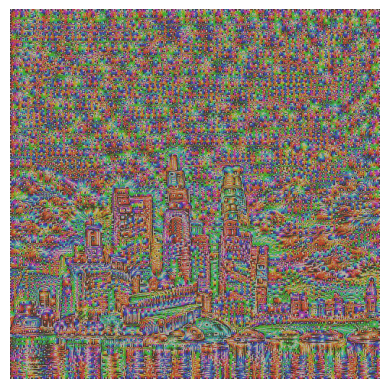

In [10]:
import matplotlib.pyplot as plt

#Deprocessing the generated image for visualization
final_image = deprocess_image(generated_image)

# Displaying the final output image
plt.imshow(final_image)
plt.axis('off')  #Hide axes
plt.show()
